# 070 Classification with Scikit-Learn

> COM6018

*Copyright &copy; 2023, 2024 Jon Barker, University of Sheffield. All rights reserved*.

## 1. Introduction

In the previous tutorial, we saw how to build a simple $k$-nearest neighbour classifier with Scikit-Learn. In this tutorial we will show how other more sophisticated classifiers can be built and evaluated. We will see how Scikit-Learn's consistent API makes it very easy to experiment with and compare different approaches.

In this tutorial, we will be using another of SciKit-Learn's inbuilt datasets, the Wisconsin breast cancer diagnosis dataset. This dataset contains 569 samples of images of cell nuclei from breast material. 212 come from samples that have been diagnosed as malignant (i.e., cancerous) and 357 as benign (i.e., non-cancerous). For each sample, 10 basic cell nuclei parameters are defined, such as radius, perimeter length, compactness, etc. For each of these parameters, multiple nuclei are measured in the sample image and the mean, standard error and worst (i.e., largest) values are reported, i.e., providing 3 x 10 = 30 features in total.

The task is to build a classifier that can distinguish between malignant and benign samples. Note that this is a two-class classification problem, which can also be referred to as a **binary classification problem**. In this case, where one of the classes refers to the 'presence' of something (i.e., cancer) the task can be considered as a **detection task**. Later, when we look at the evaluation of the classifier, we will talk separately about two different types of error, i.e., non-cancerous samples being classed as cancerous, and cancerous being classified as non-cancerous which we call **false positives** and **false negatives**, respectively.

## 2. Loading and viewing the data

As the data is a built-in dataset, loading it is very straightforward and looks similar to the code that was used to load the 'iris' dataset,

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

We can check that the data have loaded by printing out data's `DESCR` attribute.

In [2]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

Compared to the iris dataset from the last tutorial, visualisation of the data is less straightforward as there are 30 features rather than just 4. A `pairplot`, like the one used in the previous tutorial, would produce a 30 by 30 grid of scatter plots, which would be very difficult to interpret. Instead, we can use a heatmap to visualise the correlation between all pairs of features.

To make things a little easier, we will consider just the first 10 features, i.e., the features that correspond to the mean values of the cell measurements.

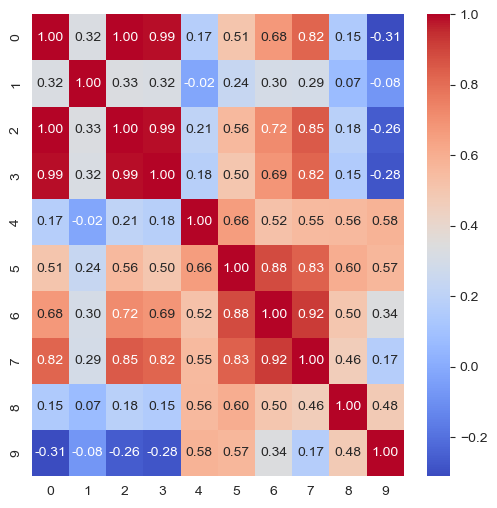

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(6,6))
sns.heatmap(np.corrcoef(data.data[:,0:10].T), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

#  0.60 Dependent relation
# -Negative one go up one go down

Note that this plot shows that features with the indexes 0, 2 and 3 are highly correlated with each other. In fact, the correlation coefficient for each pair is practically 1.0. This means that these features provide almost identical information about the sample. If we look to see what they are, we find that they are the mean radius, mean perimeter and mean area of the cell nuclei. The high correlation between these measurements is not surprising as these are all measures of the nuclei's size.

A high degree of correlation between features can cause problems for some classifiers. At the very least, it means that the classifier is receiving redundant information. It could be a sensible decision to just remove two of these three features right from the start, e.g., retain the radius feature but remove the perimeter and area features. However, we will leave them in for now and see how the different types of classifier perform.

## 3. Setting up the data split

As before, we will split the data into training and test sets. We will use the same 75/25 split that we used before.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.25, random_state=0)

Again, note how we have given a value to the `random_state` parameter to explicitly seed the internal random number generator. Recall that random number generator is used when shuffling the data prior to splitting it. Setting the seed will mean that we can reproduce the same split each time we (or others) run the code.

We will use the same train/test split for all the classifiers that follow.

## 4. Experimenting with different classifiers

In this section, we will demonstrate how Scikit-Learn can be used to easily experiment with a variety of different classifiers. We will start by repeating the use of the $k$-nearest neighbour classifier from the previous tutorial. We will then write equivalent code for three further classes of classifier,

- Support Vector Machines
- Random Forests
- Neural Networks

The purpose of this tutorial is not to delve into the theory of these particular classifiers but rather to see how the Scikit-Learn API provides a simple and consistent interface, i.e., we can swap between classifiers with very little change to the code.

### 4.1 $k$-Nearest Neighbour Classifier

We will start by repeating the $k$-nearest neighbour classifier from the previous tutorial.

We will use a value of 5 for $k$. This might not be the best value; we could optimise it using cross-validation, but we will not worry about that for now.

First, we need to train the model. Again, the code below will look identical to the code that we used when applying the classifier to the iris dataset.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

Then we measure the performance on the test set.

In [6]:
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9370629370629371


In the above, we performed the scoring in two steps: first, we ran `predict` with the test data to obtain the predicted labels, then we compared the predicted labels with the true labels to compute the score using `accuracy_score` from the metrics module. If we are not interested in seeing the actual predicted labels, then we can more conveniently perform the evaluation in a single step using the model's `score` method. This method takes the test data and test labels as arguments. Then it generates predictions and compares them with the true labels to compute the score.

In [7]:
score = model.score(X_test, y_test)
print(score)

0.9370629370629371


We achieve a score of 93.7%. This appears to be a good result, but we will now rerun the experiment using other classification techniques to see if we can do better.

### 4.2 Support Vector Machine Classifier

We will now try a different type of classifier, the **Support Vector Machine (SVM)**. The SVM classifier is a very popular classifier and is often used as a baseline for comparison with other classifiers. In brief, the SVM classifier works by finding a hyperplane (i.e., an N-dimensional plane) that separates the data into two classes. The hyperplane is chosen so that the margin between the hyperplane and the nearest data points from each class is maximised. In its basic form it finds linear (i.e., flat) planes between the classes, but a so-called `kernel` transform can be applied to the data as a preprocessing step, so although the planes are linear in the transformed space they are not linear in the original feature space.

We will use the default settings for the SVM, which uses a radial basis function (RBF) kernel. We will also use the default value for the **regularisation parameter** $C$, which is 1.0. This parameter effectively controls the hardness of the decisions the SVM makes during training: a value close to one means that the classifier makes hard (i.e., binary) decisions, whereas a lower value will 'soften' the decision. Using a lower value will help to prevent the SVM from **overfitting** the training data.

Without going into the details of how an SVM works, just look at the code below and see how similar it is to the equivalent code for the nearest neighbour classifier.

We import the SVC module class and create a default model instance. Then we 'fit' the model using the training data,

In [8]:
from sklearn.svm import SVC
model_svm = SVC()
model_svm.fit(X_train, y_train)

SVC()

After the model has been fitted (i.e., trained), we can evaluate it using the test data (again, we can use the `score` method to do this in a single step`)

In [9]:
score = model_svm.score(X_test, y_test)
print(score)

0.9370629370629371


This classifier happens to achieve the same result as the nearest-neighbour classifier, i.e., 93.7%. However, this is not always the case. The SVM and kNN classifiers are very different types of classifier and so we would expect them perform differently, e.g., we will see later that the SVM classifier can be very robust to the presence of redundant features.

### 4.3 Random Forest Classifier

We will now try a third type of classifier, the **Random Forest classifier**. This is an ensemble classifier that combines the predictions of multiple decision trees. We will use the default settings for the Random Forest, which uses 100 decision trees.

Again, without going into the details of how a Random Forest works, just examine the code below and note the similarity between this and the equivalent code for the nearest-neighbour classifier.

First we make an instance of the model that we fit using the training data,

In [10]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

Then we evaluate the model using the test data (again, we can use the `score` method to do this in a single step`)

In [11]:
score = model_rf.score(X_test, y_test)
print(score)

0.972027972027972


This classifier has performed better than the previous ones with a score of 97.2%.

### 4.4 Neural Network Classifier

Finally, we will try a fourth type of classifier, the Neural Network. We will use the default settings for the Neural Network, which uses a single hidden layer of 100 neurons. Neural network classifiers are incredibly versatile but getting the best performance requires a lot of careful design and experimentation with the hyperparameters (this is an entire research field in its own right). Here we are using just the most basic type of fully connected feed-forward neural network.

Again, without going into the details of how a Neural Network works, just look at the code below and see how similar it is to the equivalent code for the nearest-neighbour classifier.

First we fit the model using the training data,

In [12]:
from sklearn.neural_network import MLPClassifier
model_nn = MLPClassifier()
model_nn.fit(X_train, y_train)

MLPClassifier()

Then we evaluate the model using the test data (again, we can use the `score` method to do this in a single step`)

In [13]:
score = model_nn.score(X_test, y_test)
print(score)

0.8531468531468531


This time we have achieved a score of 94.4%. This is not as good as the Random Forest classifier, but still better than the nearest neighbour and SVM classifiers.

Note that with different hyperparameters, any of these models could perhaps have been tuned to give a higher score. We will return to this point shortly.

## 5. Feature preprocessing

It is generally easier to build a classifier if we start with features that have a similar distribution, i.e., similar average value and similar spread. Scikit-Learn provides a number of data pre-processing tools that help us achieve this.

### 5.1 Examining the data distribution

Let us start by comparing the distribution of the raw features in the data. There are many plot types that can be used when comparing distributions, but a common one is the so-called **boxplot**. This plot shows the median value, the interquartile range (i.e., the range between the 25th and 75th percentiles) and the total range of the data. Outliers are also shown as individual points.

We can easily generate this type of plot using the **seaborn package** that we encountered earlier in the module.

In the code below, we use the `boxplot` function from seaborn to show the distribution of the 30 visual features in three rows of 10. The first row shows the distribution of 'mean value' features, the second row the distribution of the 'standard error' features, and the third row the 'worst value' features.

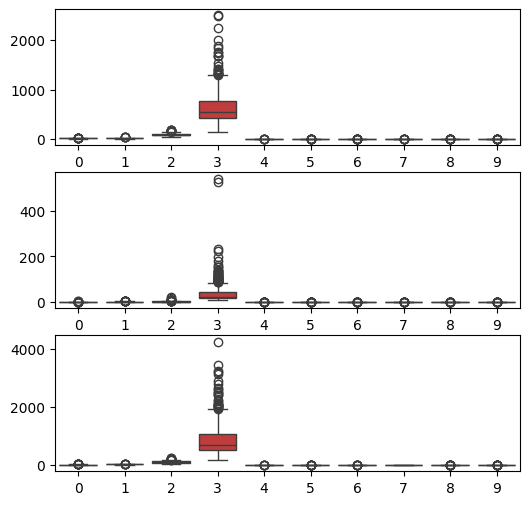

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.subplot(3,1,1)
sns.boxplot(data=X_train[:,0:10])
plt.subplot(3,1,2)
sns.boxplot(data=X_train[:,10:20])
plt.subplot(3,1,3)
sns.boxplot(data=X_train[:,20:30])
plt.show()

It can be seen from the plot that the features with indexes 2, 12 and 22 have slightly larger average values and spreads than the others, while features with indexes 3, 13 and 23 have a much greater average value and spread. These are the nucleus perimeter and area features. In fact, if we look back at the data description which we printed at the start of the tutorial, we will see that it reports a minimum and maximum value for each feature, where we can also see that the ranges vary considerably.

### 5.2 Scaling the data

In order to make the feature distributions more similar, we will apply so-called, **mean and variance scaling** to the data. This is a transformation that adjusts each feature so that it has a mean of zero and a standard deviation of one. This process is called data **standardisation**. This will make the features easier for the classifier to learn.

Scikit-Learn has a library of `transformers` which can be used for feature data pre-processing. We will use the `StandardScaler` transform that is defined in the `preprocessing` module. This works by computing an offset and scale factor for each feature and then applying the following transformation to each feature value.

This is used as follows.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In the code above, the `fit_transform` function learns the scale and offset parameters from the training data and also applies the transform to the data. The `transform` method then applies the *same* transform to the test data. Note that we do not call `fit_transform` on the test data as this would cause the test data to be scaled using a different scale and offset to that used for the training data.

We can now replot the distributions of the scaled data.

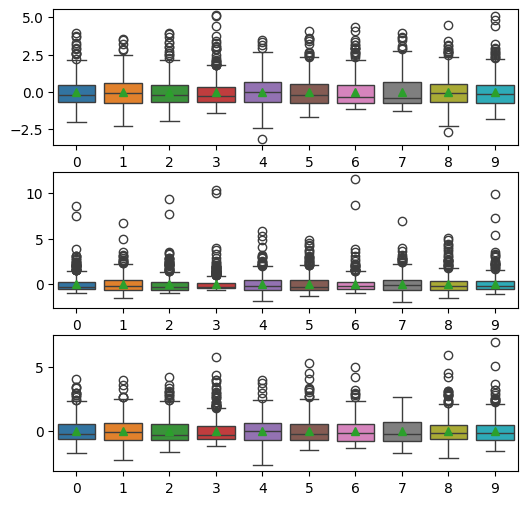

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.subplot(3,1,1)
sns.boxplot(data=X_train_scaled[:,0:10], showmeans=True)
plt.subplot(3,1,2)
sns.boxplot(data=X_train_scaled[:,10:20],showmeans=True)
plt.subplot(3,1,3)
sns.boxplot(data=X_train_scaled[:,20:30],showmeans=True)
plt.show()

As expected, the distributions of the features are now all very similar. Note that the horizontal bar in the boxplots shows the 'median' value. In the plot above the `showmeans=True` parameter has been used to add a point at the mean value. All of these should be precisely at zero.

Let us now repeat the $k$-nearest neighbour classifier using these scaled data. First, we fit the model using the scaled training data,

In [17]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

then we measure the performance on the scaled test data,

In [18]:
from sklearn import metrics
y_pred = model.predict(X_test_scaled)
print(metrics.accuracy_score(y_test, y_pred))

0.951048951048951


The score is now 95.1% which is a little better than the 93.7% that we achieved with the $k$-nearest neighbour using the non standardised data.

## 6. Hyperparameter optimisation

In the previous section, we used the default settings for each of the classifiers. However, each classifier has a number of hyperparameters that can be set to different values and which will have a big impact of the classifier's performance. We saw this with the $k$-nearest neighbour classifier, where we could set the value of $k$. However, more sophisticated classifiers have many more hyperparameters. For example, the SVM classifier has a number of different kernels that can be used, and each kernel has its own hyperparameters. The Random Forest classifier has a number of hyperparameters that control the number of trees, the depth of the trees, etc. The Neural Network classifier has hyperparameters that control the number of hidden layers, the number of neurons in each layer, the activation function, etc.

Unlike the regular classifier parameters, hyperparameter values cannot generally be learnt by the classifier's training algorithm. Further, there is no general 'right answer' for the value they should take: it will depend on many factors, such as the nature of the data, the size of the training set, etc. Therefore, we need to experiment with different values for the hyperparameters to find the best combination. This process is called **hyperparameter optimisation** and is one of the most challenging tasks faced by data scientists.

Whereas it can be straightforward to try all (sensible) values of $k$ for the nearest neighbour classifier, it is not feasible to try all possible combinations of hyperparameters for the more sophisticated classifiers. There would simply be too many different possible combinations of values. Instead, we generally need to use some form of optimisation to find a good combination of hyperparameters, without necessarily using a complete exhaustive search. These approaches can be very sophisticated. However, for this tutorial, we will stick to some simple approaches.

### 6.1 Exhaustive Grid Search

In this section, we will see how to use Scikit-Learn's `GridSearchCV` class to perform an **exhaustive grid search** over a set of hyperparameters. In a grid search, a set of allowable values is defined for each parameter and then all combinations of the allowed parameter values are tried. The best combination is then reported.

We will use the random forest classifier as an example to illustrate this approach. We will use the same train/test split as before.

The random forest classifier has several hyperparameters that we can set. We will use the following.

- `n_estimators`: the number of trees in the forest,
- `max_depth`: the maximum depth of the trees,
- `min_samples_split`: the minimum number of samples required to split an internal node,
- `min_samples_leaf`: the minimum number of samples required to be at a leaf node.

To perform a grid search, we first define a `parameter grid,` i.e., a dictionary that maps the names of the parameters onto a list of values we want to try. We then create a `GridSearchCV` object, passing it the classifier, the parameter grid, and the number of folds to use for cross-validation. Finally, we call the `fit` method to perform the grid search. The `GridSearchCV` object will then try all combinations of the parameter values and perform cross-validation on each combination. Then it will report the best combination of parameters.

The code for this is shown below.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 50}


Once it has finished, the output will look something like,

In [20]:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

Note that the grid search can take a considerable amount of time. For example, if there are N parameters and for each one we provide M allowable values to check, then there will be M<sup>N</sup> combinations to try. In this case, we have 4 parameters and 4 values for each, so there are 4<sup>4</sup> = 256 combinations to try. This is not too bad, but if we had 10 parameters and 10 values for each, then there would be 10<sup>10</sup> = 10,000,000,000 combinations to try. This would take a very long time. In practice, we would not fully evaluate all combinations but we would use some form of optimisation to try to find the best combination more quickly. We will see how to do this in the next section.

In the code above, the parameter `n_jobs=-1` tells the grid search to use all available processors to perform the cross-validation in parallel. Depending on the machine on which you run this, it may speed things up considerably.

Let us now re-evaluate the classifier using the parameters found by the grid search.

In [21]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
model_rf.fit(X_train_scaled, y_train)
score = model_rf.score(X_test_scaled, y_test)
print(score)

0.972027972027972


We have achieved a score of 97.2%, which is a little better than the score obtained before. In this case the default parameters were already good and the hyperparameter optimisation has not produced much gain. However, this will not always be the case.

Regardless of the type of classifier that is being used, the process to tune the hyperparameters would be the same. However, the names and suitable values of the parameters that are defined in the parameter grid dictionary will vary.

Note that the grid search requires that we have chosen suitable values for the parameter grid. Before searching over the full grid, it can be a good strategy to first vary one parameter at a time while leaving others at their default values. This allows us to quickly scope out the range of values that are likely to be good. We can then use this information to design the parameter grid.

### 6.2 Grid Search with Successive Halving

The grid search is very inefficient because all parameter settings are fully evaluated, i.e., with the complete cross-validation test set. This is wasteful because some parameter settings are clearly worse than others and could have perhaps been rejected on the basis of a much smaller test sample. The **Successive Halving (SH)** approach takes advantage of this fact to arrive at a good search result more efficiently.

With SH, we first consider all possible parameter combinations and evaluate them with a small amount of resource (i.e., a small test set). Then we discard the worst half of the parameter combinations and re-evaluate the remaining combinations with a larger amount of resource (i.e., a larger test set). We repeat this process until we are left with just one parameter combination. This is the best combination found by the search.

Implementing this strategy from scratch would be quite tricky, but luckily Scikit-Learn provides a `HalvingGridSearchCV` class that implements this strategy for us. Using this class, the code for the SH approach will look very similar to the standard search, but we now simply replace `GridSearchCV` with `HalvingGridSearchCV`. The `HalvingGridSearchCV` constructor takes a parameter `factor` that defines the ratio of the size of the test set between successive halving steps, i.e., for halving this is set to 2.

In [11]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [4, 6, 8, 10], #Depth of tree
    'min_samples_split': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}
# 4*4*4*4 = 256 Combinations

grid_search = HalvingGridSearchCV(RandomForestClassifier(), param_grid, factor=2, cv=5)
#Fold cv=5
#5 classifier * 256


grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

NameError: name 'X_train_scaled' is not defined

In [ ]:
#{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 10}

The output of this is

In [23]:
{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 50}

{'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 50}

We can test the performance,

In [24]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=6, min_samples_leaf=1, min_samples_split=6, n_estimators=50)
model_rf.fit(X_train_scaled, y_train)
score = model_rf.score(X_test_scaled, y_test)
print(score)

0.958041958041958


The score of 96.5% is again about the same as before. For large training datasets the search would run considerably faster than the standard `GridSearchCV`. However, for this small dataset the speed improvement is not particularly noticeable.

## 7. Pipelines

In the experiments above, we first made a standardised copy of the data (i.e., `X_train_scaled` and `X_test_scaled`) and we then used this copy to fit and evaluate the models. It would be very easy to make mistakes when doing things this way. For example, we might have standardised the training data, but then forgot to standardise the test data. Or we might have standardised the test data using a different standardisation to the training data. In both cases, the model would not perform as expected. We can solve this problem by using a Scikit-Learn **pipeline**.

### 7.1 Defining and fitting a pipeline

To simplify the code and avoid mismatching the processing applied to training and evaluation, Scikit-Learn introduces the concept of **processing pipelines** which are encapsulated by the `Pipeline` class. A pipeline allows us to define all the preprocessing steps and the classifier as a single object that can then be fitted and evaluated in a single step. This simplifies our code and ensures that the same pre-processing is applied to both the training and the test data.

The code below shows how to define a pipeline that first applies the standardisation and then applies the random forest classifier.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
# Parse list of tuples, Obj StandardScaler()

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

In [26]:
rf_pipeline.fit(X_train, y_train)
score = rf_pipeline.score(X_test, y_test)
print(score)

0.965034965034965


Note how the pre-processed versions of the data never need to be stored in explicit variables. Also, `rf_pipeline` acts just like a new estimator and can be employed anywhere where the original estimator was used. This means that it can also be used in the context of a grid search. For example, the code below performs a grid search over the hyperparameters of the random forest classifier using our newly defined `rf_pipeline` object.

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [6, 8, 10],
    'rf__min_samples_split': [6, 8, 10]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5)

grid_search.fit(X_train, y_train)

# Replace rf_pipeline with the best estimator found by the grid search
rf_pipeline = grid_search.best_estimator_

score = rf_pipeline.score(X_test, y_test)
# score it will be saved as model 

In [28]:
print(score)

0.972027972027972


Pipelines can have arbitrarily many data transform stages, but they should always end with an estimator. For example, in addition to feature normalisation, we might want to perform data cleaning stages such as removing outliers and/or filling in missing values. Additionally, our pre-processing might include a feature selection or data dimensionality reduction stage. We will see examples of these more complex pipelines in later tutorials.

### 7.2 Improving the pipeline efficiency with caching

Although pipelines make the code easy to read and right, if care is not taken they can introduce serious inefficiencies. For example, in the above pipeline the standardisation is performed each time the pipeline is fitted (which will be many times during the grid search algorithm). This is wasteful, as the standardisation stage will have the same inputs and outputs each time. Although the standardisation is not very computationally expensive, we may have had more costly stages in the pipeline that we would want to avoid recomputing unnecessarily.

We can improve efficiency by using the `memory` parameter of the `Pipeline` constructor. This allows us to specify a directory where the intermediate results of each stage of the pipeline can be **cached**. This means that if the pipeline is fitted multiple times, then the standardisation will only be performed once, i.e., it will look in the cache and retrieve the already computed result if it exists.

The code for this looks very similar to that before, but note the additional parameter in the `Pipeline` constructor. Note that we would typically use a temporary directory for the cache, and this can be constructed using the `mkdtemp` function of the Python `tempfile` module. The Pipeline constructor can take the name of this directory directly, e.g., like this.

In [29]:
import tempfile
temp_dir_name = tempfile.mkdtemp()
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
], memory=temp_dir_name)

Alternatively, a more sophisticated approach is to use the Python `joblib` module that provides a `Memory` class that can be used to create a cache. This can provide additional functionality, such as logging the use of the cache. The Memory object constructor takes the temporary directory name as a parameter. The Pipeline constructor can then take the Memory object as a parameter, i.e., like this,

In [30]:
from joblib import Memory
import tempfile

temp_dir_name = tempfile.mkdtemp()
cache = Memory(location=temp_dir_name, verbose=0)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
], memory=cache)

The full code is shown below.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
], memory='cache')  # This parameter

rf_pipeline.fit(X_train, y_train)

#rf__ = random forest Hyperparam
# Ex. scalar__param1
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [6, 8, 10],
    'rf__min_samples_split': [6, 8, 10]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5)

grid_search.fit(X_train, y_train)

# Replace rf_pipeline with the best estimator found by the grid search
rf_pipeline = grid_search.best_estimator_

score = rf_pipeline.score(X_test, y_test)

In [32]:
print(score)

0.972027972027972


The code in the cell above will run fractionally faster than the same code without the cache. You can experiment with this by removing the "memory='cache'" parameter from the Pipeline constructor and then running the code again. You should see that the code runs a little slower. In general, the amount of time saved will depend on the size of the dataset and the complexity of the pipeline.

## 8. Receiver Operator Curves (ROC)

So far, we have only looked at the overall accuracy of the classifier. However, this does not tell us how the classifier is performing on each specific class. For example, in the breast cancer dataset, we are interested in how well the classifier performs for the malignant class. We can get more insight into this by looking at the confusion matrix.

In [33]:
from sklearn.metrics import confusion_matrix
y_pred = rf_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

In [34]:
print(cm)

[[52  1]
 [ 3 87]]


We can see from confusion matrix that the classifier is mistaking one malignant case as non-malignant (i.e., a false negative) and three non-malignant cases as malignant (i.e., false positives). If this was a medical application, we would be more concerned about the false negatives, as this would mean that a patient with cancer would be treated as healthy and then would not be treated.

For a binary classifier such as this, we can change the behaviour of the classifier by biasing it towards choosing one class over another. This can be done by estimating a probability for the sample belonging to the positive class (i.e., cancer present) and then defining a threshold above which we would output this class (i.e., changing the **detection threshold**). In normal behaviour, we would output the positive class if the probability is greater than 0.5. However, we could raise or lower this threshold: If we lower the threshold, the system will report more positive cases and fewer false negatives, i.e., the **false negative rate (FNR)** would decrease, but at the expense of a higher **false positive rate (FPR)**.

In order to get a complete picture of the classifier's behaviour, it is typical to evaluate its false positive and false negative rate over a range of detection thresholds.  When we do this, we usually display the results by plotting a graph of the **true positive rate (TPR)**  versus the **false positive rate (FPR)**. This is called a **Receiver Operator (ROC) curve**. With this graph available, a user can then decide how best to set the threshold, i.e., at which point on the ROC curve they want the system to operate.

```{Note}
The true positive rate is related to the false negative rate by $TPR = 1 - FNR$. Similarly, the false positive rate and the true negative rate are related by $FPR = 1 - TNR$. i.e., there are two independent quantities but four different names: which name is used depends on the context.
```

Scikit-Learn provides a single function `RocCurveDisplay` that computes the TPR and FPR over a range of threshold values and plots the corresponding ROC curve. We can use this as follows.

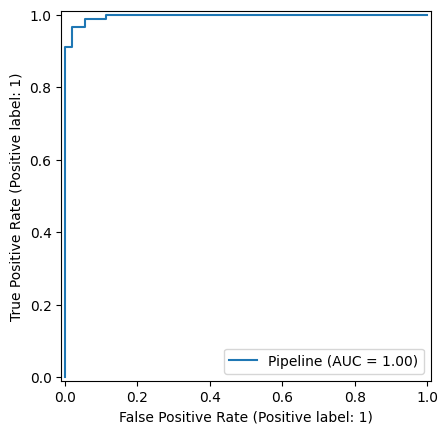

In [35]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test)
plt.show()

Taking this plot as an example, say we want the false negative rate to be close to zero, i.e., given that TPR = 1 - FNR, we want the TPR to be close to 1.0.  We can see from the plot that the lowest FPR value that can achieve this is about 0.2. This means that if this was a screening test, in order not to miss cancerous cases (i.e., to have an FNR close to 0), then 20% of the healthy subjects would receive false positive results, i.e. 20% of the healthy people would be referred for further investigation. This would probably be unacceptable in a real application -- we would need a better classifier.

In truth, this dataset is actually far too small to be able to reliably train and evaluate a model. We could use a leave-one-out testing regime to get more value from the data, but to build a classifier that performs significantly better and approaches the performance needed for real application, we would probably need to find a bigger training dataset and perhaps a better set of features.

## 9. Summary

In this tutorial, we have covered a lot of ground. We have seen how to use Scikit-Learn to build and evaluate a number of different classifiers. We have seen how to use Scikit-Learn's `GridSearchCV` and `HalvingGridSearchCV` classes to perform hyperparameter optimisation. We have also seen how to use Scikit-Learn's `Pipeline` class to define a pipeline that encapsulates both the data preprocessing and the classifier. Finally, we have seen how to use Scikit-Learn's `RocCurveDisplay` class to plot the ROC curve for a binary classifier.

For each of these topics, we have only had space to cover the most basic usage. Having used this tutorial to gain an overview, you are encouraged to read the excellent Scikit-Learn documentation (<https://scikit-learn.org/stable/index.html>) which comes complete with many examples showing how the tools can be applied to real problems.